#  LSTM and fbprophet and fbprophet)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import seaborn as sns
#import pmdarima as pm
from dateutil.relativedelta import relativedelta
import warnings
warnings.simplefilter(action='ignore')
from sklearn.metrics import accuracy_score
import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import prophet
from numpy import median
import math
import statistics

In [2]:
# reading and inserting the csv sheet into DataFrame
df = pd.read_csv('sales_train_validation.csv')
df.head(3)
calendar= pd.read_csv('calendar.csv')

In [23]:
# No null cells!!
df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

In [3]:
df.drop(columns=['item_id', 'dept_id','cat_id','store_id','state_id'],axis=1, inplace=True) # Drop the unnecessary columns
data = df.T  # seting the days as index for new dataframe(Data)
data.columns = df['id'] # ading product id column to Data 
data.index.name = None   # remove the name of index
data.drop(index='id',inplace=True) # remove the first row
# change the format and the freq. of index to datetime format
data.index = calendar['date'][0:1913]
data.index = pd.to_datetime(data.index)
data.index.freq= 'd'
data.index

DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', length=1913, freq='D')

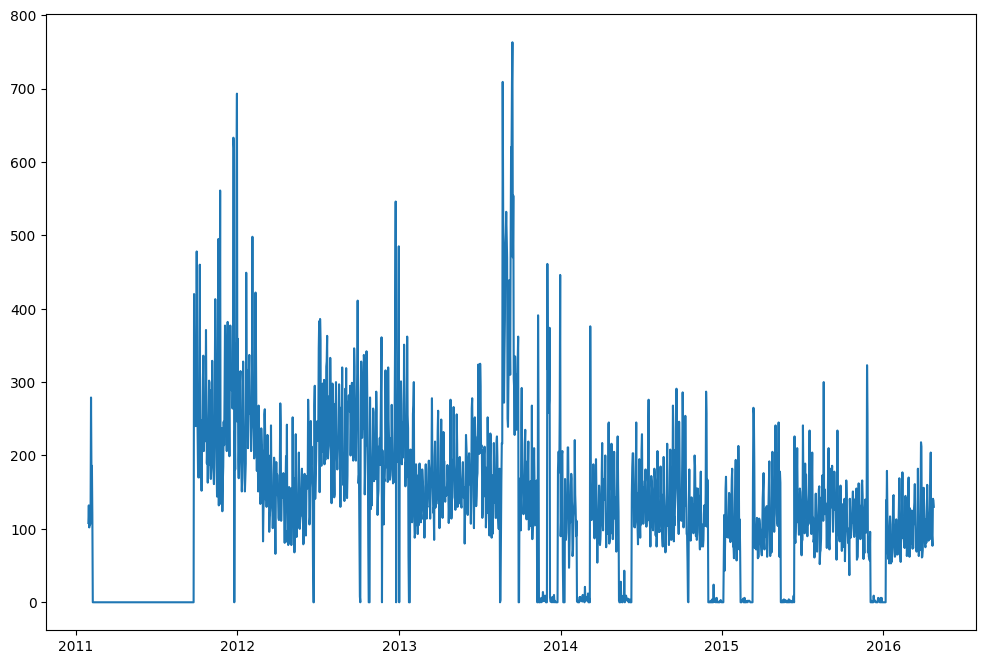

In [25]:
will be ecluded from time series 
plt.figure(figsize=(12,8))
plt.plot(data.index,data['FOODS_3_090_CA_3_validation'])

adf is -4.173018148719141
pvalue is 0.0007317275745300243


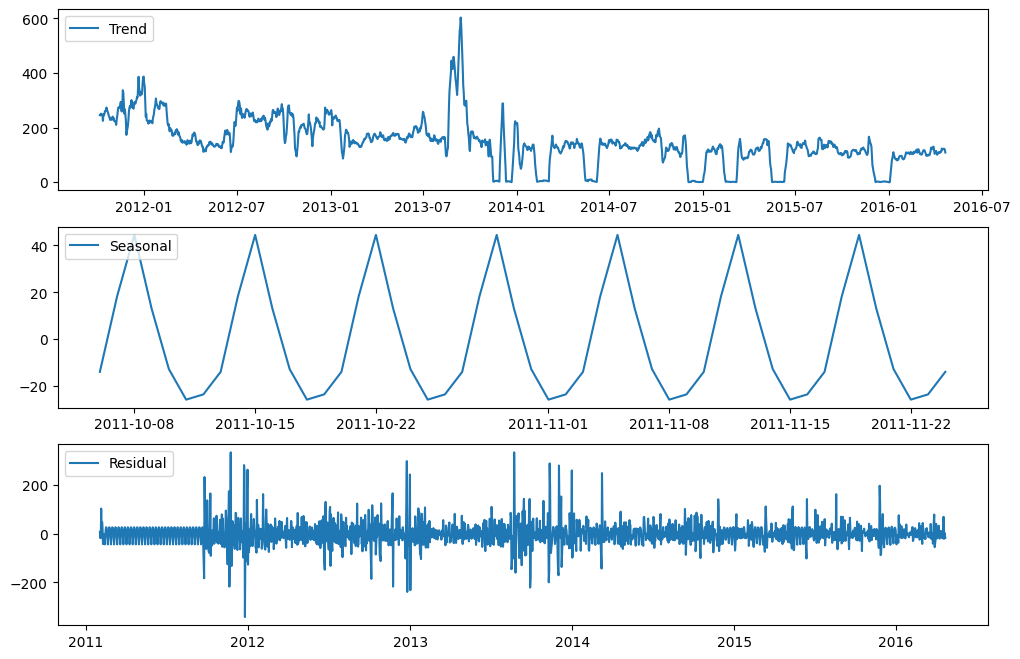

In [27]:
# Using the decompostion method...
ss_decomposition = seasonal_decompose(x=data['FOODS_3_090_CA_3_validation'])
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[250:],estimated_trend[250:], label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[250:300],estimated_seasonal[250:300], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index,estimated_residual, label='Residual')
ax[2].legend(loc='upper left')

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['FOODS_3_090_CA_3_validation'])

print(f'adf is {adf}')
print(f'pvalue is {pvalue}')


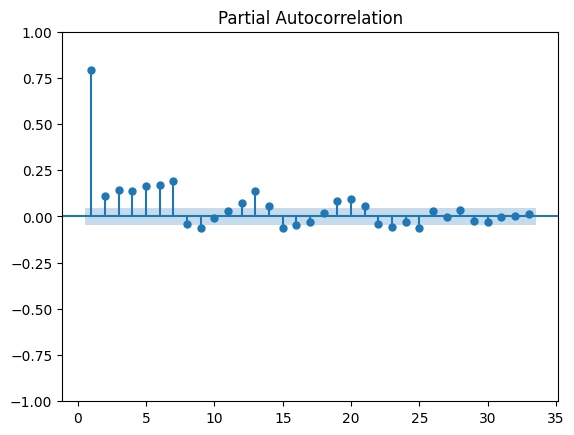

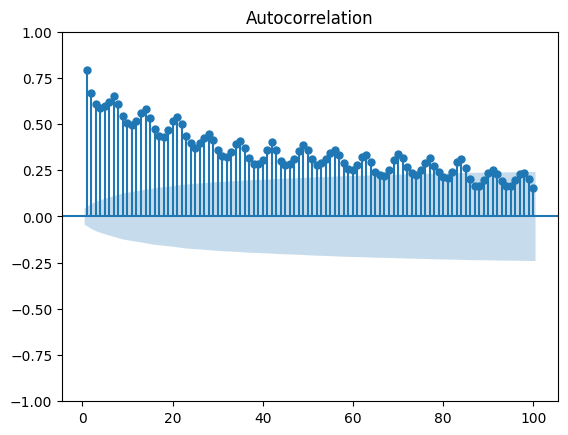

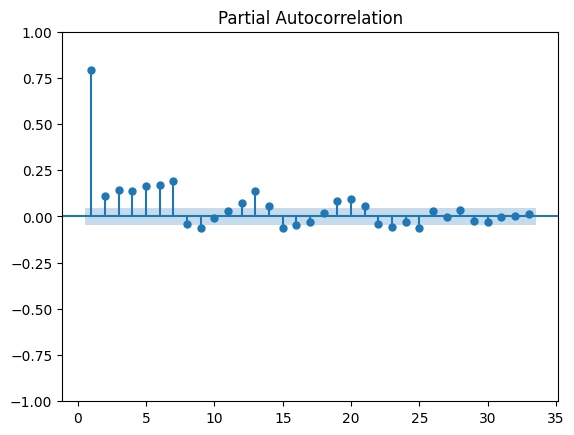

In [28]:
#plt.subplot(3,1,4)
plot_acf(data['FOODS_3_090_CA_3_validation'],lags=100, zero=False)


#plt.subplot(3,1,5)
plot_pacf(data['FOODS_3_090_CA_3_validation'], zero=False)

adf is -9.690404728774496
pvalue is 1.1405330819670496e-16


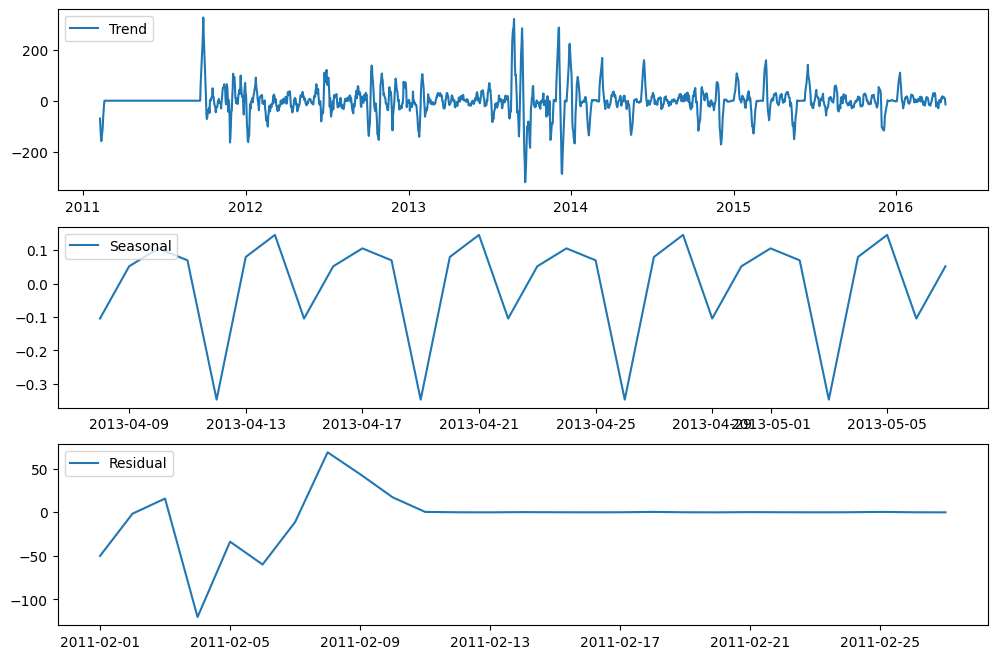

In [5]:
# diffrencing method

data['shift'] = data['FOODS_3_090_CA_3_validation'].shift(7)
data['week_lag'] = data['FOODS_3_090_CA_3_validation'] - data['shift']

ss_decomposition = seasonal_decompose(x=data['week_lag'].dropna())
lag_trend = ss_decomposition.trend
lag_seasonal = ss_decomposition.seasonal
lag_residual = ss_decomposition.resid

#fig, ax = plt.subplots(3,1, figsize=(12,8))
fig, ax = plt.subplots(3,figsize=(12,8) )
#plt.figure(figsize=(12,5))
#plt.subplot(3,1,1)
ax[0].plot(data.index[7:],lag_trend, label='Trend')
ax[0].legend(loc='upper left')

#plt.subplot(3,1,2)
ax[1].plot(data.index[800:830],lag_seasonal[800:830], label='Seasonal')
ax[1].legend(loc='upper left')

#plt.subplot(3,1,3)
ax[2].plot(data.index[:30],lag_residual[:30], label='Residual')
ax[2].legend(loc='upper left')

adf_dif, pvalue_dif,usedlag, nobs, critical_values, icbest = adfuller(data['week_lag'].dropna())

print(f'adf is {adf_dif}')
print(f'pvalue is {pvalue_dif}')


## SARIMA MODEL

In [6]:
start_interval = 250 # removing the intial interval where no sold item data is shown
test_sample= 100
train_SARIMA = data['FOODS_3_090_CA_3_validation'][start_interval:-test_sample].astype('float')
test_SARIMA = train_SARIMA[-test_sample:].astype('float')
train_LSTM = data['FOODS_3_090_CA_3_validation'][start_interval:-2*test_sample].astype('float')
test_LSTM = data['FOODS_3_090_CA_3_validation'][-2*test_sample:-test_sample].astype('float')
train_prophet = data[['FOODS_3_090_CA_3_validation']][start_interval:-test_sample].astype('float')
true = data['FOODS_3_090_CA_3_validation'][-test_sample:].astype('float')
print('full data length', data[['FOODS_3_090_CA_3_validation']][start_interval:].shape)
print('train_SARIMA', train_SARIMA.shape)
print('test_SARIMA', test_SARIMA.shape)
print('train_LSTM', train_LSTM.shape)
print('test_LSTM', test_LSTM.shape)
print("train prophet", train_prophet.shape)
print("true ", true.shape)

full data length (1663, 1)
train_SARIMA (1563,)
test_SARIMA (100,)
train_LSTM (1463,)
test_LSTM (100,)
train prophet (1563, 1)
true  (100,)


In [59]:
# Custamized grid search


p_min,p_max = 0,3
d_min,d_max= 0,2
q_min,q_max = 0,2

P_min,P_max = 0,3
D_min, D_max = 0,2
Q_min,Q_max = 0,2

trend= 'n' # ['n','c','t','ct']
m=42

p_m = int(round(median([p_min,p_max]),0))
d_m = int(round(median([d_min,d_max]),0))
q_m = int(round(median([q_min,q_max]),0))
P_m = int(round(median([P_min,P_max]),0))
D_m = int(round(median([D_min,D_max]),0))          
Q_m = int(round(median([Q_min,Q_max]),0))          
          

start_time_init = time.time()
duppl_order = []

result = []

if (p_m,d_m,q_m) != (p_max,d_max,q_max):
    order = (p_m,q_m,d_m)
    seasonal_order = (P_m,D_m,Q_m,m)
    
    
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_m,d_m,q_m),'seasonal_order': seasonal_order,'rmse':rmse_m}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_m,q_m,d_m):', rmse_m)

    
    order = (p_max,d_max,q_max)
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_max,d_max,q_max),'seasonal_order': seasonal_order,'rmse':rmse_max}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_max,d_max,q_max):',rmse_max)

    order = (p_min,d_min,q_min)
    if order + seasonal_order in duppl_order:
        pass
    else:
        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
        rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
        result.append(({'order': (p_min,q_min,d_min),'seasonal_order': seasonal_order,'rmse':rmse_min}))
        duppl_order.append(order+seasonal_order)
        print(order,seasonal_order,'rmse_(p_min,d_min,q_min):',rmse_min)
    
   
    if rmse_max < rmse_min:
        p_loop = range(p_m,p_max)
        d_loop = range(d_m,d_max)
        q_loop = range(q_m,q_max)
    else:
        p_loop = range(p_min,p_m)
        d_loop = range(d_min,d_m)
        q_loop = range(q_min,q_m)
        
        
    for p_ in p_loop:
        for d_ in d_loop:
            for q_ in q_loop:
                start_time = time.time()
                order=(p_,d_,q_)
                seasonal_order = (P_m,D_m,Q_m,m)
                if order + seasonal_order in duppl_order:
                    pass
                else:
                    model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
                    yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                    rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                    result.append(({'order':order,'seasonal_order':seasonal_order,'rmse':rmse}))
                    duppl_order.append(order+seasonal_order)
                    duration = time.time() - start_time
                    print(order,seasonal_order,'rmse:' ,rmse , 'duration:',duration)
                    
    output = pd.DataFrame(result)
    fit_model = output[output['rmse'] == (output['rmse'].min())]
    order_fit = fit_model.order.values[0]
    
    
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        order = order_fit
        seasonal_order = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
        
        seasonal_order = (P_max,D_Max,Q_Max,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
        
        seasonal_order = (P_min,D_min,Q_min,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)

        
        if rmse_max < rmse_min:
            P_loop = range(P_m,P_max)
            D_loop = range(D_m,D_max)
            Q_loop = range(Q_m,Q_max)
        else:
            P_loop = range(P_min,P_m)
            D_loop = range(D_min,D_m)
            Q_loop = range(Q_min,Q_m)
        
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    order = order_fit
                    seasonal_order = (P_,D_,Q_,m)
                    if order + seasonal_order in duppl_order:
                        pass
                    else:
                        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
                        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                        rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                        result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                        duppl_order.append(order+seasonal_order)
                        duration = time.time() - start_time
                        print(order,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
    
    
    else:
        order = order_fit
        seasonal_order_best = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'rmse:',rmse)

else:
    order = (p_m,q_m,d_m)
    if (P_m,D_m,Q_m) != (P_max,D_max,Q_max):
        
        
        seasonal_order = (P_m,D_m,Q_m,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_m = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_m,D_m,Q_m,m),'rmse':Rmse_m}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_m,D_m,Q_m,m):', Rmse_m)
        
        seasonal_order =  (P_max,D_max,Q_max,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_max = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_max,D_max,Q_max,m),'rmse':Rmse_max}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_max,D_max,Q_max,m):',Rmse_max)
            
        seasonal_order = (P_min,D_min,Q_min,m)
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            Rmse_min = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order_fit,'seasonal_order': (P_min,D_min,Q_min,m),'rmse':Rmse_min}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'Rmse_(P_min,D_min,Q_min,m):',Rmse_min)
        
        
            
        if rmse_max < rmse_min:
            P_loop = range(P_m,P_max)
            D_loop = range(D_m,D_max)
            Q_loop = range(Q_m,Q_max)
            
        else:
            P_loop = range(P_min,P_m)
            D_loop = range(D_min,D_m)
            Q_loop = range(Q_min,Q_m)
            
        
        for P_ in P_loop:
            for D_ in D_loop:
                for Q_ in Q_loop:
                    start_time = time.time()
                    
                    seasonal_order = (P_,D_,Q_,m)
                    if order + seasonal_order in duppl_order:
                        pass
                    else:
                        model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order= seasonal_order, trend='n').fit()
                        yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
                        rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
                        result.append(({'order':order_fit,'seasonal_order':(P_,D_,Q_,m),'rmse':rmse}))
                        duppl_order.append(order+seasonal_order)
                        duration = time.time() - start_time
                        print(order,(P_,D_,Q_,m),'rmse:' ,rmse , 'duration:',duration)
        
        
        output2 = pd.DataFrame(result)
        fit_model2 = output2[output2['rmse'] == (output2['rmse'].min())]
        print('best model: ',fit_model2.order.values,fit_model2.seasonal_order.values, 'rmse:', fit_model2.rmse.values)
        
    else:
        seasonal_order = (P_m,D_m,Q_m,m)
        
        if order + seasonal_order in duppl_order:
            pass
        else:
            model2 = sm.tsa.statespace.SARIMAX(train_SARIMA[-400:], order=order, seasonal_order=seasonal_order, trend='n').fit()
            yhat = round(model2.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True),0)
            rmse = math.sqrt(sum(pow((yhat - true),2))/len(true))
            result.append(({'order': order,'seasonal_order': seasonal_order,'rmse':rmse}))
            duppl_order.append(order+seasonal_order)
            print(order,seasonal_order,'rmse:',rmse)
 
duration = time.time() - start_time_init

print('Full total time: ',duration)

(2, 1, 1) (2, 1, 1, 42) rmse_(p_m,q_m,d_m): nan
(3, 2, 2) (2, 1, 1, 42) rmse_(p_max,d_max,q_max): nan
(0, 0, 0) (2, 1, 1, 42) rmse_(p_min,d_min,q_min): nan
(1, 0, 0) (2, 1, 1, 42) rmse: nan duration: 13.045164346694946


IndexError: index 0 is out of bounds for axis 0 with size 0

**Building and fitting SARIMX model**

In [60]:
start_time = time.time()
seasonal_order = (2, 1, 1, 42)
order_m = (2,1,1)
model_sarima = sm.tsa.statespace.SARIMAX(train_SARIMA, order=order_m, seasonal_order=seasonal_order, trend='n').fit()
duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

training is done within:1.1117542346318563 minutes


In [61]:
# out of sample prediction for (100 days):
yhat_sarima = model_sarima.predict(start = '2016-01-16' , end= '2016-04-24', dynamic=True)

**Calculating the Rmse for SARIMX model for 100 days,The rmse trend going up as forcasting days increases**

In [62]:
sarimax_Rmse = []
for i in np.arange(10,100,10):
    sarimax_Rmse.append(math.sqrt(sum(pow((yhat_sarima[:i] - true[:i]),2))/len(true[:i])))
sarimax_Rmse

[nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [65]:
future_fcst = model_sarima.get_forecast(1000)
# That will have a method to pull in confidence interval 
confidence_int = future_fcst.conf_int(alpha = 0.01)
confidence_int['yhat'] = abs(confidence_int['lower FOODS_3_090_CA_3_validation'] + confidence_int['upper FOODS_3_090_CA_3_validation'])
confidence_int

,lower FOODS_3_090_CA_3_validation,upper FOODS_3_090_CA_3_validation,yhat
2013-07-30,-55.823053,267.389059,211.566006
2013-07-31,-51.741428,297.787563,246.046135
2013-08-01,-28.721440,328.682600,299.961160
2013-08-02,6.548861,369.207380,375.756242
2013-08-03,48.152101,415.552687,463.704788
...,...,...,...
2016-04-20,-1482.656340,1772.585898,289.929558
2016-04-21,-1483.230587,1774.432925,291.202338
2016-04-22,-1450.510589,1809.572399,359.061810
2016-04-23,-1401.783407,1860.717261,458.933854


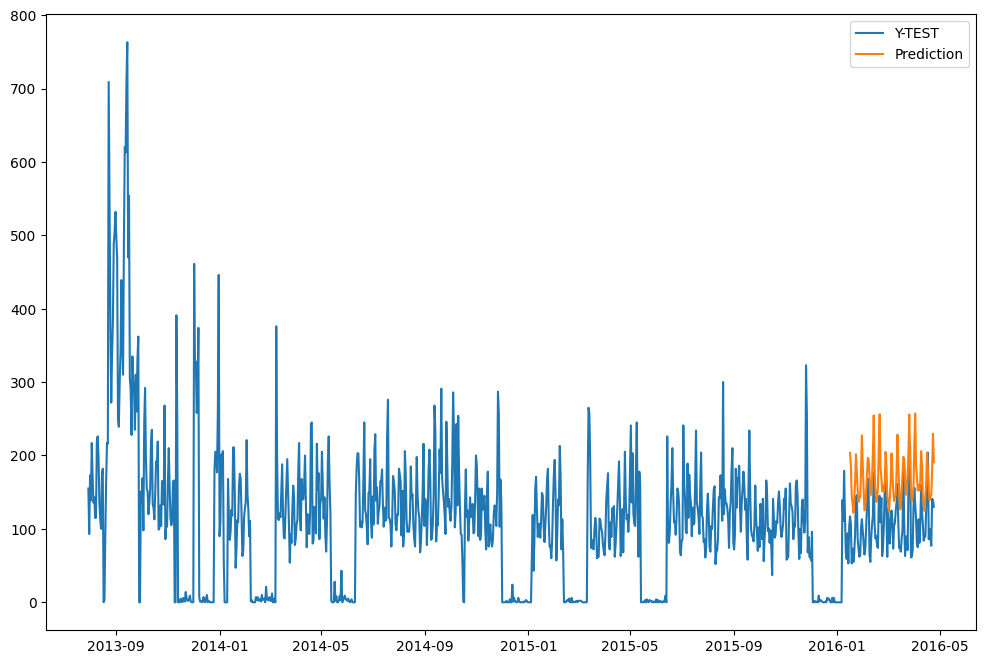

In [66]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Y-TEST')
plt.plot(yhat_sarima, label='Prediction')
plt.savefig('sarima2.png')
plt.legend()

**Plot the diagnostics**

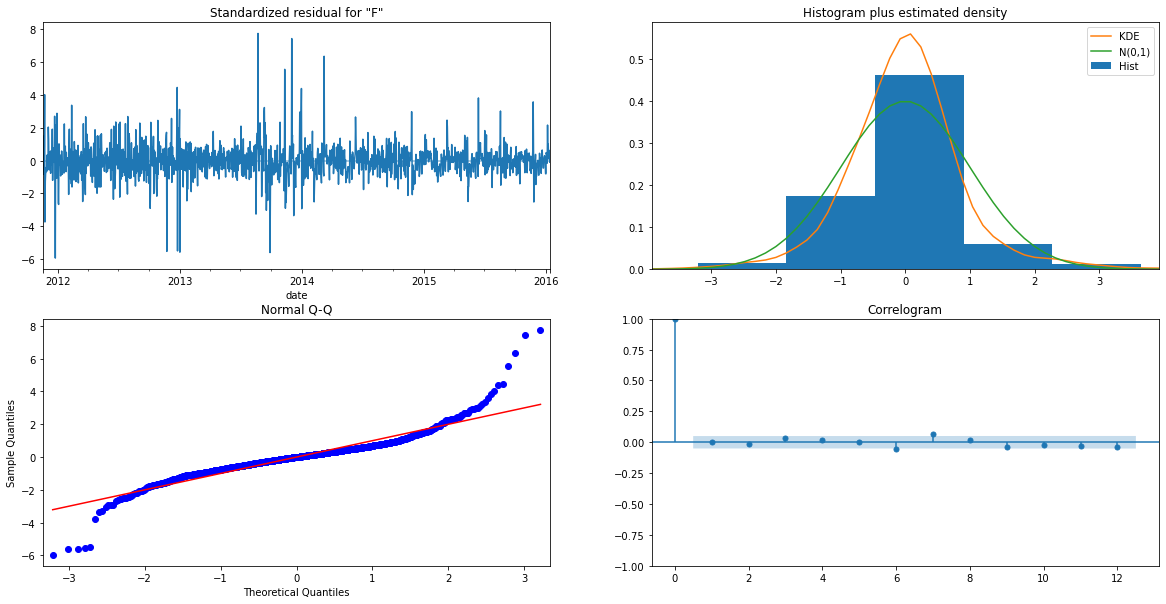

In [68]:
model_sarima.plot_diagnostics(lags=12,figsize = (20,10),);

## LSMT Model

In [7]:
# Create x_train,y_train for LSTM model

input_days = 12
x_train, y_train = [],[]
for i in range(0,train_LSTM.shape[0] - input_days,3):
    x_train.append(train_LSTM[i:i+input_days])
    y_train.append(train_LSTM[i+input_days])

    
x_train = np.array(x_train)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
y_train = np.asarray(y_train)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)

x_train shape (484, 12, 1)
y_train shape (484,)


In [8]:
# building simple LSMT model:

start_time = time.time()
cell_units = 1000
epochs = 100

model_LSTM = Sequential() 

model_LSTM.add(LSTM(cell_units,input_shape=(x_train.shape[1],1))) #return_sequences= True))
    

model_LSTM.add(Dense(1))
    

model_LSTM.compile(loss='mean_squared_error', optimizer='adam')
model_LSTM.fit(x_train, y_train, epochs=epochs, batch_size=64, verbose=1)


duration = (time.time() - start_time) / 60
print(f'training is done within:{duration} minutes')

Epoch 1/100
8/8 [==============================] - 3s 139ms/step - loss: 32865.1250
Epoch 2/100
8/8 [==============================] - 1s 139ms/step - loss: 28173.9785
Epoch 3/100
8/8 [==============================] - 1s 140ms/step - loss: 25580.1934
Epoch 4/100
8/8 [==============================] - 1s 140ms/step - loss: 23898.7129
Epoch 5/100
8/8 [==============================] - 1s 140ms/step - loss: 22397.2969
Epoch 6/100
8/8 [==============================] - 1s 140ms/step - loss: 21105.4941
Epoch 7/100
8/8 [==============================] - 1s 139ms/step - loss: 19913.9844
Epoch 8/100
8/8 [==============================] - 1s 140ms/step - loss: 18860.0078
Epoch 9/100
8/8 [==============================] - 1s 139ms/step - loss: 17871.6133
Epoch 10/100
8/8 [==============================] - 1s 140ms/step - loss: 16997.1133
Epoch 11/100
8/8 [==============================] - 1s 140ms/step - loss: 16183.1797
Epoch 12/100
8/8 [==============================] - 1s 140ms/step - loss: 

8/8 [==============================] - 1s 140ms/step - loss: 4778.4014
Epoch 99/100
8/8 [==============================] - 1s 139ms/step - loss: 4797.4761
Epoch 100/100
8/8 [==============================] - 1s 139ms/step - loss: 4836.9653
training is done within:1.9349305510520936 minutes


In [9]:
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________


***

**Forcasting (LSTM model)**

***

In [10]:
# Creating x_test data (its shape should be match with training data and with input_shape)
x_test = []
for i in range(0,test_LSTM.shape[0] - input_days + 1):
    x_test.append(test_LSTM[i:i + input_days])
               
x_test = np.asarray(x_test)    
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
print('x_test shape', x_test.shape)


x_test shape (89, 12, 1)


In [11]:
# prediction function which goes through each row where each row contains 12 data cells and each cell value will be replaced by predicted value...
pred = []

for i in range(x_test.shape[0]):
    for _ in range(x_test.shape[1]):
        prediction = model_LSTM.predict(x_test[i:i+1,:,:])
        pred.append(prediction)
        x_test[i,:-1,:] = x_test[i,1:,:]
        x_test[i,-1,:] = prediction

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


In [12]:
# Reshape the output of precidiction array from (89,12,1) shape to (100,) shape (input_days = 12)
yhat_lstm = np.arange(0,100,1,'float')
y_flatten = x_test.flatten()
yhat_lstm[:input_days] = y_flatten[:input_days] # 
k = 2
for i in range(input_days,test_LSTM.shape[0]):
    yhat_lstm[i] = y_flatten[(k*input_days) - 1]  # {formula:2*input_days - 1}
    k +=1
    
lstm_result = pd.DataFrame(data=yhat_lstm, index=true.index, columns=['yhat'])
lstm_result['true'] = true

**Rmse for LSTM**

In [13]:
lstm_Rmse = []

for i in np.arange(10,100,10):
    lstm_rmse = math.sqrt(sum(pow((lstm_result['yhat'][:i] - true[:i]),2))/len(true[:i]))
    lstm_Rmse.append(lstm_rmse)
lstm_Rmse



[44.4067928576427,
 50.421570405596874,
 48.79122384222071,
 49.89721201402254,
 47.34959072208387,
 49.94100822082782,
 55.034873968677665,
 69.51778272225005,
 74.04476863628601]

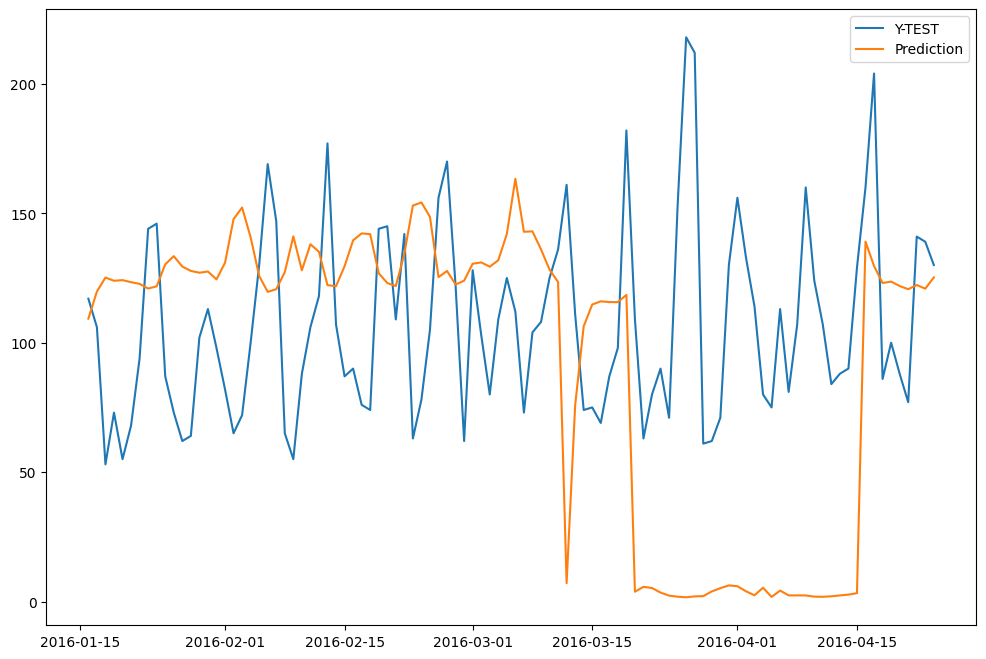

In [15]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Y-TEST')
plt.plot(lstm_result.yhat, label='Prediction')
plt.savefig('lstmSMALL.png')
plt.legend()

## fbprophet Model

In [19]:
# prepare dataframe for fprophet model
train_prophet['ds'] = train_prophet.index.values
train_prophet.rename(columns={'FOODS_3_090_CA_3_validation':'y'},inplace=True)
train_prophet = train_prophet[['ds','y']]
train_prophet.columns.name = None
train_prophet

,ds,y
date,,
2011-10-06,2011-10-06,249.0
2011-10-07,2011-10-07,254.0
2011-10-08,2011-10-08,460.0
2011-10-09,2011-10-09,170.0
2011-10-10,2011-10-10,229.0
...,...,...
2016-01-11,2016-01-11,68.0
2016-01-12,2016-01-12,59.0
2016-01-13,2016-01-13,94.0


In [20]:
#fprophet model without holidays
start_time = time.time()
m = prophet(weekly_seasonality=True)
m.fit(train_prophet)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

duration = time.time() - start_time
print(f'training is done within:{duration} minutes')


plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(Without Holidays) --- Ground Truth Vs Predicted(Rmse= 76')
plt.ylabel('Sales')
plt.legend()

TypeError: 'module' object is not callable

In [21]:
#fprophet model with holidays

holidays = calendar[calendar['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

start_time = time.time()

m_holi = Prophet(weekly_seasonality=True,holidays=holidays)
m_holi.fit(train_prophet)

future = m_holi.make_future_dataframe(periods=100)
forecast = m_holi.predict(future)
predicted_prophet = forecast[['yhat']][-test_sample:]
predicted_prophet.set_index(true.index,inplace=True)
predicted_prophet.index

print(f'training is done within:{duration} minutes')



NameError: name 'Prophet' is not defined

**fbprophet Rmse**

In [80]:
prophet_Rmse = []
for i in np.arange(10,100,10):
    prophet_rmse = math.sqrt(sum(pow((predicted_prophet.yhat[:i] - true[:i]),2))/len(true[:i]))
    prophet_Rmse.append(prophet_rmse)
prophet_Rmse

[23.912905732564404,
 24.01517243909483,
 44.07209660270271,
 65.6974302447992,
 79.75649553366466,
 80.84491338960707,
 77.11078682173546,
 76.3784306087999,
 75.30203185214124]

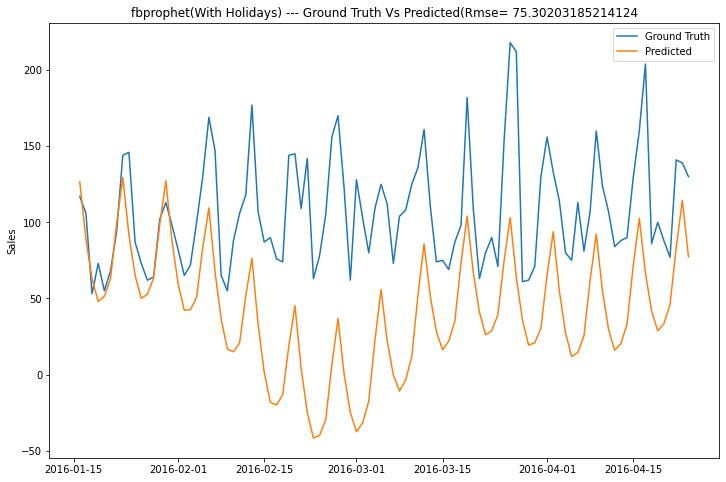

In [83]:
plt.figure(figsize=(12,8))
plt.plot(true, label='Ground Truth')
plt.plot(predicted_prophet, label='Predicted')
plt.title('fbprophet(With calendar)')
plt.ylabel('Sales')
plt.legend()

## Recomended Model

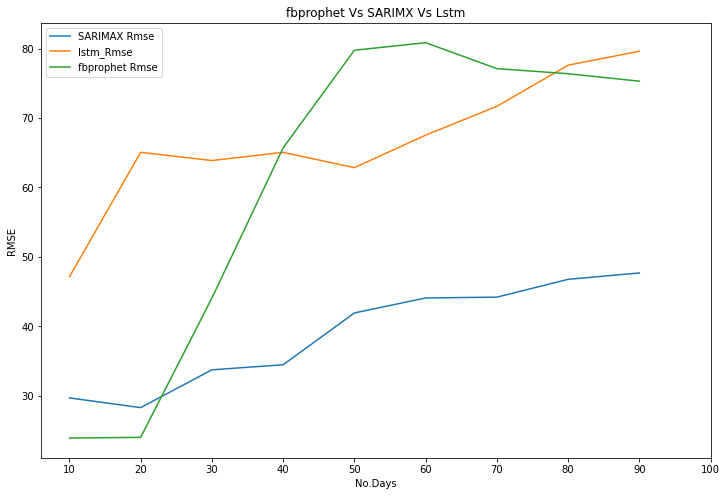

In [84]:
plt.figure(figsize=(12,8))
plt.plot(sarimax_Rmse, label='SARIMAX Rmse')
plt.plot(lstm_Rmse, label='lstm_Rmse')
plt.plot(prophet_Rmse, label='fbprophet Rmse')
plt.ylabel('RMSE')
plt.xlabel('No.Days')
plt.title('fbprophet Vs SARIMX Vs Lstm')
plt.xticks(np.arange(10), ['10', '20', '30','40', '50', '60','70', '80', '90','100'])
plt.legend()

| Model | Training Time (Minutes) }
| --- | --- |
| SARIMAX | 5.8 |
| fbprophet | 3.0 |
| LSTM | 35.0* , 1.7** |
*(By using CPU only)
**(By using GPU)

